In [1]:
import xarray as xr

import numpy as np

from matplotlib.colors import BoundaryNorm, ListedColormap

import cartopy.mpl.ticker as cticker

import scipy.stats as stats

import pandas as pd

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

import glob

import datetime

import matplotlib.pyplot as plt

import pickle

import cartopy.crs as ccrs

import cartopy.feature as cfeature

from scipy.stats import spearmanr

import seaborn as sns

import os

import matplotlib.colors as mcolors

from matplotlib.colors import TwoSlopeNorm

from sklearn.metrics import silhouette_score

from scipy.stats import pearsonr

from pathlib import Path

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

pd.options.mode.chained_assignment = None

In [108]:
# saturation values for soil types -> fwi = vsm/(vsm at saturation) *vsm = volumetric soil moisture

# sat_1 = 0.403

# sat_2 = 0.439 

# sat_3 = 0.430

# sat_4 = 0.520

# wet_soil_avg = 0.7 * ((sat_1 + sat_2 + sat_3 + sat_4)/4)

# dry_soil_avg = 0.4 * ((sat_1 + sat_2 + sat_3 + sat_4)/4)

thresholds: for wilting points < 0.15, for optimal water > 0.35

IFS documentation https://www.ecmwf.int/en/elibrary/79697-ifs-documentation-cy41r2-part-iv-physical-processes 

In [2]:
# volumetric soil moisture

data_path = "~/data/era5sgp/era5_sl_sm_full_sgp/"

file_pattern = os.path.join(data_path, "*.nc")

all_sm = xr.open_mfdataset(file_pattern, combine="by_coords")

all_sm['valid_time'] = all_sm['valid_time'] - pd.Timedelta(hours=6)

In [3]:
# soil type

data_path = "~/data/era5sgp/era5_sl_soil_type_full_sgp/"

file_pattern = os.path.join(data_path, "*.nc")

all_st = xr.open_mfdataset(file_pattern, combine="by_coords")

all_st['valid_time'] = all_st['valid_time'] - pd.Timedelta(hours=6)

soil_type = all_st['slt'].load().data

In [4]:
# soil type into dataframe

all_st = all_st.assign_coords(date=all_st['valid_time'].dt.floor('D'))

time_vals = all_st['date'].values  # Extract time coordinates

lat_vals = all_st['latitude'].values  # Extract latitude coordinates

lon_vals = all_st['longitude'].values  # Extract longitude coordinates

time_grid, lat_grid, lon_grid = np.meshgrid(time_vals, lat_vals, lon_vals, indexing='ij')

stdf = pd.DataFrame({
    
    'date': time_grid.flatten(),
    
    'lat': lat_grid.flatten(),
    
    'lon': lon_grid.flatten(),
    
    'st': soil_type.flatten()
})

In [5]:
## setting volumentric soil moisture 

stdf['vsm'] = np.where(stdf['st'] == 1, 0.403, 
               np.where(stdf['st'] == 2, 0.439, 
               np.where(stdf['st'] == 3, 0.430, 
               np.where(stdf['st'] == 4, 0.520, np.nan))))

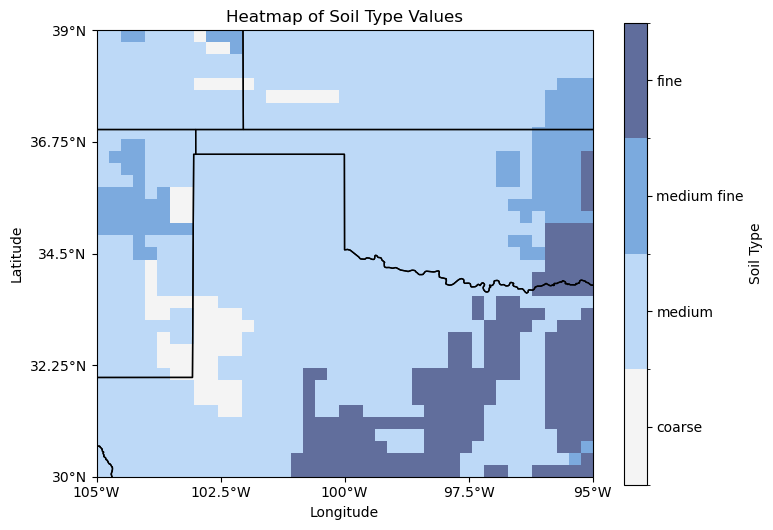

In [6]:
stdf_grouped = stdf.groupby(['lat', 'lon'])['st'].mean().reset_index()

grid = stdf_grouped.pivot(index='lat', columns='lon', values='st')

# Extract the sorted unique latitude and longitude values
lat_grid = grid.index.values

lon_grid = grid.columns.values

# The pivoted grid is already your st_grid, but note that its shape might be transposed compared to your original method.
st_grid = grid.values

# Define boundaries for 4 discrete levels using one extra boundary value
levels = [0.5, 1.5, 2.5, 3.5, 4.5]

# Create a discrete colormap with exactly 4 distinct colors
cmap = ListedColormap(['#f0f0f0', '#a1c9f4', '#4386d1', '#1d2f72'])

norm = BoundaryNorm(levels, cmap.N, clip=True)

# Create the figure and axis using Cartopy
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features
ax.add_feature(cfeature.COASTLINE)

ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)

ax.add_feature(cfeature.STATES, linestyle='-', linewidth=1, edgecolor='black')

# Determine the extent of the image from the min and max values of lon and lat
extent = (lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max())

# Plot the heatmap using imshow
heatmap = ax.imshow(st_grid, extent=extent, origin='lower', cmap=cmap, norm=norm, alpha=0.7)

# Add a colorbar with ticks for the discrete levels
cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical', label='Soil Type')

cbar.set_ticks([1, 2, 3, 4])

cbar.ax.set_yticklabels(['coarse', 'medium', 'medium fine', 'fine'])

# Add latitude and longitude ticks using Cartopy tick formatters
lon_ticks = np.linspace(lon_grid.min(), lon_grid.max(), 5)

lat_ticks = np.linspace(lat_grid.min(), lat_grid.max(), 5)

ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())

ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

# Format the ticks to show degree symbols
lon_formatter = cticker.LongitudeFormatter()

lat_formatter = cticker.LatitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)

ax.yaxis.set_major_formatter(lat_formatter)

# Set labels and title

ax.set_title("Heatmap of Soil Type Values")

ax.set_xlabel("Longitude")

ax.set_ylabel("Latitude")

plt.show()

In [7]:
# soil moisture 

all_sm = all_sm.assign_coords(date=all_sm['valid_time'].dt.floor('D'))

daily_mean_sm = all_sm['swvl2'].groupby('date').mean(dim='valid_time').load()

In [8]:
# putting soil moisture into df

time_vals = daily_mean_sm['date'].values  # Extract time coordinates

lat_vals = daily_mean_sm['latitude'].values  # Extract latitude coordinates

lon_vals = daily_mean_sm['longitude'].values  # Extract longitude coordinates

sm_values = daily_mean_sm.values  # 3D array of soil moisture values

time_grid, lat_grid, lon_grid = np.meshgrid(time_vals, lat_vals, lon_vals, indexing='ij')

smdf = pd.DataFrame({
    
    'date': time_grid.flatten(),
    
    'lat': lat_grid.flatten(),
    
    'lon': lon_grid.flatten(),
    
    'sm': sm_values.flatten()
})

In [10]:
# joining soil moisture and soil type together

fullsm = smdf.merge(stdf[['date', 'lat', 'lon', 'vsm']], on=['date', 'lat', 'lon'], how='inner')

fullsm['fwi'] = fullsm['sm'] / fullsm['vsm']

fullsm['saturation'] = np.where(fullsm['fwi'] <= 0.4, 'dry', 
                              
                              np.where(fullsm['fwi'] >= 0.7, 'wet', 'moderate'))

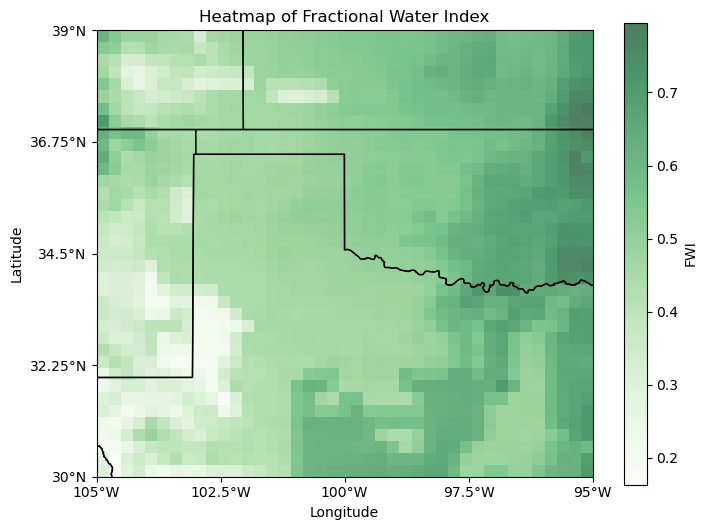

In [12]:
fullsm_grouped = fullsm.groupby(['lat', 'lon'])['fwi'].mean().reset_index()

# Pivot the DataFrame so that rows are latitudes, columns are longitudes, and values are 'sm'
grid = fullsm_grouped.pivot(index='lat', columns='lon', values='fwi')

# Get the grid values for latitudes, longitudes, and the 'sm' grid
lat_grid = grid.index.values
lon_grid = grid.columns.values
sm_grid = grid.values

# Create a continuous colormap (using a built-in colormap, e.g., 'viridis')
cmap = plt.get_cmap('Greens')

# Create the figure and axis using Cartopy
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add geographic features
ax.add_feature(cfeature.COASTLINE)

ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)

ax.add_feature(cfeature.STATES, linestyle='-', linewidth=1, edgecolor='black')

# Define the extent from the min and max values of lon and lat
extent = (lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max())

# Plot the continuous data using imshow
# Adjust 'origin' to 'lower' so that the data aligns correctly with latitudes
img = ax.imshow(sm_grid, extent=extent, origin='lower', cmap=cmap, alpha=0.7)

# Add a colorbar with a label
cbar = plt.colorbar(img, ax=ax, orientation='vertical', label='FWI')
# Optionally, you can format the colorbar tick labels if desired

# Set latitude and longitude ticks
lon_ticks = np.linspace(lon_grid.min(), lon_grid.max(), 5)

lat_ticks = np.linspace(lat_grid.min(), lat_grid.max(), 5)

ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())

ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

# Use Cartopy's tick formatters for proper degree formatting
lon_formatter = cticker.LongitudeFormatter()

lat_formatter = cticker.LatitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)

ax.yaxis.set_major_formatter(lat_formatter)

# Set labels and title
ax.set_title("Heatmap of Fractional Water Index")

ax.set_xlabel("Longitude")

ax.set_ylabel("Latitude")

plt.show()


In [13]:
fullsm[(fullsm['lat']==36.5) & (fullsm['lon']==-97.5)]['saturation'].value_counts()

saturation
moderate    1946
wet          463
dry          345
Name: count, dtype: int64

In [14]:
with open('fullsm.pkl', 'wb') as f:
    
    pickle.dump(fullsm, f)